In [65]:
import torch
from torchvision.datasets import ImageFolder
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from pathlib import Path
"""
Contain for setting updata with full func to create dataloader
"""

def create_dataloader(
                    train_transform: transforms.Compose,
                    val_transform: transforms.Compose,
                    test_transform: transforms.Compose,
                    **kwargs,
                ):
    dataset_path = Path(kwargs['dataset']['dataset_path'])
    
    train_path = dataset_path / kwargs['dataset']['folder_train']
    val_path = dataset_path / kwargs['dataset']['folder_val']
    test_path = dataset_path / kwargs['dataset']['folder_test']

    train_data = CocoDetection(
        root= train_path,
        annFile= train_path / '_annotations.coco.json',
        transform= train_transform
    )

    val_data = CocoDetection(
        root= val_path,
        annFile= val_path / '_annotations.coco.json',
        transform= val_transform
    )

    test_data = CocoDetection(
        root= test_path,
        annFile= test_path / '_annotations.coco.json',
        transform= test_transform
    )
    
    train_dataloader = DataLoader(
        dataset= train_data,
        batch_size= kwargs['dataset']['batch_size'],
        shuffle= True
    )
    
    val_dataloader = DataLoader(
        dataset= val_data,
        batch_size= kwargs['dataset']['batch_size'],
        shuffle= False
    )

    test_dataloader = DataLoader(
        dataset= test_data,
        batch_size= kwargs['dataset']['batch_size'],
        shuffle= False
    )
    return train_dataloader, val_dataloader, test_dataloader

In [66]:
config = {
    'dataset' : {
        'dataset_path':'./datasets',
        'folder_train': 'train',
        'folder_val': 'train2',    
        'folder_test': 'train2',
        'batch_size': 32,
    },
    'train_para': {
        'pretrain_model_path': './runs/classify/train0',
        'epoch': 1,
        'learning_rate': 0.001
    },
    'save_para': {
        'model_name': 'model.pth',
        'graph_loss_name': 'loss_acc.jpg',
        'graph_confmat_name': 'confusion_matrix.jpg',
        'info_file_name': 'info.json'
    }
}

In [68]:
train_dataloader, val_dataloader, test_dataloader = create_dataloader(
    train_transform = transforms.ToTensor(),
    val_transform = transforms.ToTensor(),
    test_transform = transforms.ToTensor(),
    **config
)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

In [92]:
import torch
from torch import nn
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models import resnet50, ResNet50_Weights

from pathlib import Path
import json


def mask_rcnn_model(class_names: None|list = None, pretrain_model_path: None|str= None, device: str= 'cpu'):
    info_data = None
    if pretrain_model_path is None:
        weights = ResNet50_Weights.DEFAULT
        model = resnet50(weights= weights).to(device)
        model.fc = nn.Sequential(
            nn.Linear(in_features=2048, out_features=len(class_names), bias=True)
        )
        model = model.to(device)
        
    else:
        pretrain_model_path = Path(pretrain_model_path)

        with open(pretrain_model_path / 'info.json', 'r') as f:
            info_data = json.load(f)
        
        model = resnet50().to(device)
        model.fc = nn.Sequential(
            nn.Linear(in_features=2048, out_features=len(info_data['class_names']), bias=True)
        )
        model.load_state_dict(torch.load(f=pretrain_model_path / 'model.pth'))
        model = model.to(device)
        
    return model, info_data

In [9]:
import torch
from torch import nn
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models import resnet50, ResNet50_Weights

from pathlib import Path
import json

device = 'cuda'

pretrain_model_path = Path('./runs/classify/train1')

with open(pretrain_model_path / 'info.json', 'r') as f:
    info_data = json.load(f)

model = resnet50().to(device)
model.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=len(info_data['class_names']), bias=True)
)
model.load_state_dict(torch.load(f=pretrain_model_path / 'model.pth'))
model = model.to(device)

In [49]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights

# mask_rcnn = maskrcnn_resnet50_fpn(weights_backbone=model)
faster_rcnn = fasterrcnn_resnet50_fpn_v2(weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)
faster_rcnn

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

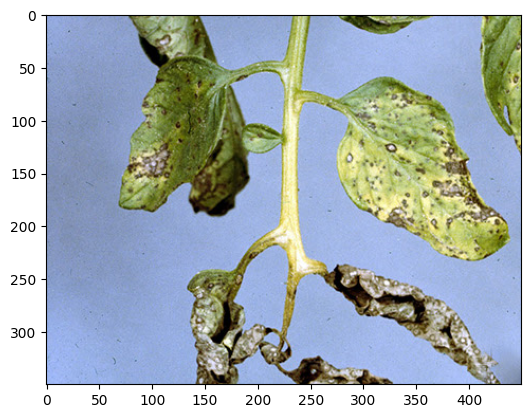

In [50]:
from torchvision import transforms
from PIL import Image
import torch 
import cv2 

val_transforms_data = transforms.Compose([
        # transforms.Resize(size= 800),
        transforms.ToTensor()
    ])

# img = Image.open('./datasets/train/001079539470452029_JPG.rf.03746d2b5e79c14f42a0f00945e592c1.jpg')
# img = Image.open('./unnamed.jpg')
img = cv2.cvtColor(cv2.imread('./unnamed.jpg'), cv2.COLOR_BGR2RGB)
img_tensor = val_transforms_data(img)

img_tensor_in_batch = img_tensor.unsqueeze(dim= 0)

faster_rcnn.eval()

with torch.inference_mode():
    results = faster_rcnn(img_tensor_in_batch)

plt.imshow(img)

In [51]:
results

[{'boxes': tensor([[6.4605e+01, 5.7673e+00, 4.4164e+02, 2.9422e+02],
          [1.7529e+02, 3.2415e+02, 3.4239e+02, 3.4993e+02],
          [6.8542e+01, 7.9962e-01, 1.9132e+02, 1.8536e+02],
          [6.6509e+01, 0.0000e+00, 2.0662e+02, 1.9363e+02],
          [7.4681e+01, 9.9246e-02, 1.6327e+02, 5.0240e+01]]),
  'labels': tensor([16, 59, 88, 16, 16]),
  'scores': tensor([0.1346, 0.1051, 0.0970, 0.0815, 0.0732])}]

In [52]:
import matplotlib.pyplot as plt

boxes = results[0]['boxes'].cpu().numpy()
labels = results[0]['labels'].cpu().numpy()
scores = results[0]['scores'].cpu().numpy()

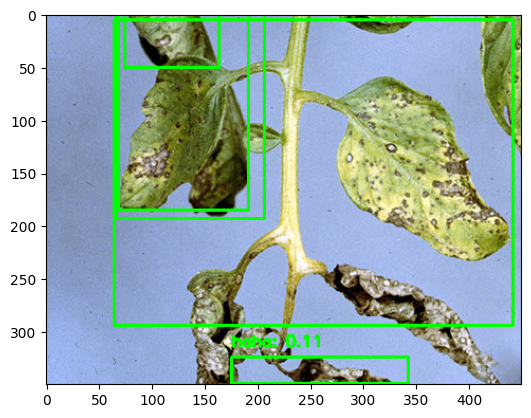

In [53]:
import cv2

score_threshold = 0.0

# Vẽ các bounding boxes và nhãn lên ảnh
for i, box in enumerate(boxes):
    if scores[i] > score_threshold:
        # Lấy tọa độ bounding box
        x1, y1, x2, y2 = box.astype(int)
        
        # Vẽ bounding box
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Vẽ nhãn và điểm số
        # label = COCO_INSTANCE_CATEGORY_NAMES[labels[i]]
        score = scores[i]
        text = f'haha: {score:.2f}'
        cv2.putText(img, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.imshow(img)

In [46]:
from torchinfo import summary
import torchvision

summary(model=mask_rcnn, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
MaskRCNN (MaskRCNN)                                     [32, 3, 224, 224]    [0, 4]               --                   Partial
├─GeneralizedRCNNTransform (transform)                  [32, 3, 224, 224]    [32, 3, 800, 800]    --                   --
├─BackboneWithFPN (backbone)                            [32, 3, 800, 800]    [32, 256, 13, 13]    --                   Partial
│    └─IntermediateLayerGetter (body)                   [32, 3, 800, 800]    [32, 2048, 25, 25]   --                   Partial
│    │    └─Conv2d (conv1)                              [32, 3, 800, 800]    [32, 64, 400, 400]   (9,408)              False
│    │    └─FrozenBatchNorm2d (bn1)                     [32, 64, 400, 400]   [32, 64, 400, 400]   --                   --
│    │    └─ReLU (relu)                                 [32, 64, 400, 400]   [32, 64, 400, 400]   --                   --

In [4]:
import os
from pathlib import Path
import torch
import json
import matplotlib.pyplot as plt
import seaborn as sns

from torchmetrics import ConfusionMatrix

def plot_loss_curves(results: dict[str, list[float]]):
    train_loss = results['train_loss']
    val_loss = results['val_loss']
    train_accuracy = results['train_acc']
    val_accuracy = results['val_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='train_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    return plt

def plot_confmat(table):
    plt.figure(figsize=(11, 8))
    sns.heatmap(table, annot=True, fmt='.0f')
    plt.title('Confusion Matrix')

    return plt

def save_model(model: torch.nn.Module,
               results: dict[str, list[float]],
               class_names: list,
               device: str,
               **kwargs):

    confmat = ConfusionMatrix(task="multiclass", num_classes= len(class_names)).to(device)
    
    preds = torch.tensor(results['test_results']['preds']).to(device)
    target = torch.tensor(results['test_results']['target']).to(device)
    table = confmat(preds, target).tolist()
    
    
    
    target_dir = Path('runs/classify/')
    target_dir.mkdir(parents=True, exist_ok=True)
    
    model_name = kwargs['save_para']['model_name']
    graph_loss_name = kwargs['save_para']['graph_loss_name']
    graph_confmat_name = kwargs['save_para']['graph_confmat_name']
    info_file_name = kwargs['save_para']['info_file_name']
    
    train_paths = os.listdir(target_dir)
    
    i = 0
    
    while True:
        train_path = f'train{i}'
        if train_path not in train_paths:
            break
        else:
            i += 1

    target_dir = target_dir / train_path
    
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,exist_ok=True)
    
    model_save_path = target_dir_path / model_name
    graph_loss_save_path = target_dir_path / graph_loss_name
    graph_confmat_save_path = target_dir_path / graph_confmat_name
    info_save_path = target_dir_path / info_file_name
    
    print(f"[INFO] Saving model to: {target_dir}")
    
    info_data = {
        "class_names" : class_names,
        "results" : results
    }
    
    with open(info_save_path, 'w') as f:
        json.dump(info_data, f, indent=4)
        
    graph_loss = plot_loss_curves(results)
    graph_loss.savefig(graph_loss_save_path)

    graph_confmat = plot_confmat(table)
    graph_confmat.savefig(graph_confmat_save_path)
    
    torch.save(obj=model.state_dict(), f=model_save_path)

In [5]:
import torch
from torchmetrics import Accuracy
from tqdm.auto import tqdm

def __train(model: torch.nn.Module,
            dataloader: torch.utils.data.DataLoader,
            loss_func: torch.nn.Module,
            optimizer: torch.optim.Optimizer,
            mectric_func: Accuracy,
            device: str):
    
    train_loss = 0
    train_acc = 0
    
    model.train()

    for _, (X, y) in enumerate(tqdm(dataloader, desc= '-----Train')):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_func(y_pred, y)

        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim= 1), dim= 1)
        train_acc += mectric_func(y_pred, y).item()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    
    return train_loss, train_acc

def __val(model: torch.nn.Module,
           dataloader: torch.utils.data.DataLoader,
           loss_func: torch.nn.Module,
           mectric_func: Accuracy,
           device: str):

    val_loss = 0
    val_acc = 0
    
    model.eval()
    
    with torch.inference_mode():
        for _, (X, y) in enumerate(tqdm(dataloader, desc= '-------Val')):
            X, y = X.to(device), y.to(device)
            
            y_pred = model(X)
            loss = loss_func(y_pred, y)
            
            val_loss += loss.item()
            
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim= 1), dim= 1)
            val_acc += mectric_func(y_pred, y).item()

        val_loss /= len(dataloader)
        val_acc /= len(dataloader)

    return val_loss, val_acc

def __test(model: torch.nn.Module,
           dataloader: torch.utils.data.DataLoader,
           device: str):
    
    model.eval()
    target = torch.tensor([]).to(device)
    preds = torch.tensor([]).to(device)
    print('\n\n')
    with torch.inference_mode():
        for _, (X, y) in enumerate(tqdm(dataloader, desc= '------Test')):
            X, y = X.to(device), y.to(device)

            
            y_pred = model(X)
            
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim= 1), dim= 1)

            target = torch.cat((target, y), dim= 0)
            preds = torch.cat((preds, y_pred_class), dim= 0)

    test_results = {
        'preds' : preds.tolist(),
        'target' : target.tolist()
    }

    return test_results

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_func: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          mectric_funcs: Accuracy,
          epochs: int,
          info_data: list,
          device: str):

    if info_data is None:
        results = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_results' : {}
        }
    else:
        results = info_data['results']
    torch.manual_seed(42) 
    torch.cuda.manual_seed(42)

    for epoch in tqdm(range(epochs), desc= 'Training'):
        print(f"\n\nEpoch: {epoch+1:2} ------------")
        train_loss, train_acc = __train(model=model,
                                        dataloader=train_dataloader,
                                        loss_func=loss_func,
                                        optimizer=optimizer,
                                        mectric_func=mectric_funcs,
                                        device= device)
        
        val_loss, val_acc = __val(model=model,
                                dataloader=val_dataloader,
                                loss_func=loss_func,
                                mectric_func=mectric_funcs,
                                device= device)
        
        print(f"Epoch: {epoch+1:2} | Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.5f} | Val Acc: {val_acc:.4f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    results["test_results"] = __test(model=model,
                                     dataloader=test_dataloader,
                                     device= device)
    return results

In [7]:
import torch
from torch import nn
from torchvision import transforms

from pathlib import Path
from torchmetrics import Accuracy, ConfusionMatrix

# from model.data_setup import create_dataloader
# from model.engine import train
# from model.utils import save_model
# from model.model_builder import resnet50_model

def run(**kwargs):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Device: '{device}'")
    
    train_transforms_data = transforms.Compose([
        transforms.RandomResizedCrop(size=(224, 224), antialias=True),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor()
    ])
    
    val_transforms_data = transforms.Compose([
        transforms.Resize(size= 224),
        transforms.ToTensor()
    ])

    test_transforms_data = transforms.Compose([
        transforms.Resize(size= 224),
        transforms.ToTensor()
    ])
    
    train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloader(train_transform=train_transforms_data,
                                                                                      val_transform=val_transforms_data,
                                                                                      test_transform=test_transforms_data,
                                                                                      **kwargs)


    model, info_data = resnet50_model(class_names= class_names, pretrain_model_path= kwargs['train_para']['pretrain_model_path'], device= device)
    
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params= model.parameters(), lr= kwargs['train_para']['learning_rate'])
    
    accur = Accuracy(task='multiclass', num_classes= len(class_names)).to(device)
    
    results = train(
            model= model,
            train_dataloader= train_dataloader,
            val_dataloader= val_dataloader,
            test_dataloader= test_dataloader,
            loss_func= loss_func,
            optimizer= optimizer,
            mectric_funcs= accur,
            epochs= kwargs['train_para']['epoch'],
            info_data = info_data,
            device= device
    )
    
    save_model(model= model, results= results, class_names= class_names, device= device, **kwargs)

Device: 'cuda'


Training:   0%|          | 0/1 [00:00<?, ?it/s]



Epoch:  1 ------------


-----Train:   0%|          | 0/32 [00:00<?, ?it/s]

-------Val:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch:  1 | Train Loss: 0.33747 | Train Acc: 0.8936 | Val Loss: 0.17936 | Val Acc: 0.9512





------Test:   0%|          | 0/313 [00:00<?, ?it/s]

[INFO] Saving model to: runs\classify\train5


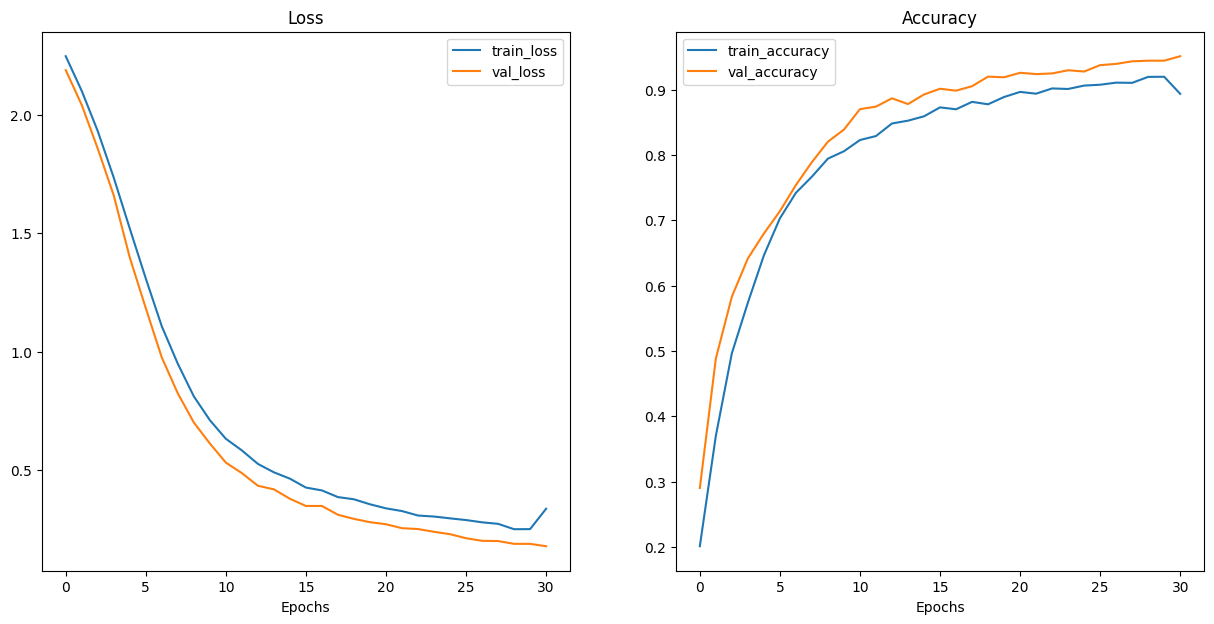

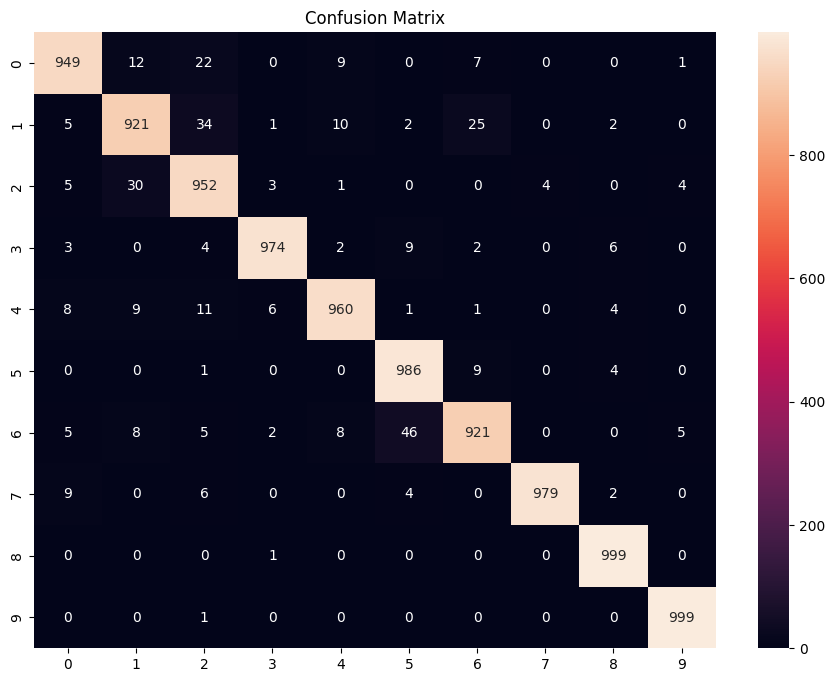

In [6]:
from model import train

config = {
    'dataset' : {
        'dataset_path':'./datasets/tomato',
        'folder_train': 'val',
        'folder_val': 'val',    
        'folder_test': 'train',
        'batch_size': 32,
    },
    'train_para': {
        'pretrain_model_path': './runs/classify/train0',
        'epoch': 1,
        'learning_rate': 0.001
    },
    'save_para': {
        'model_name': 'model.pth',
        'graph_loss_name': 'loss_acc.jpg',
        'graph_confmat_name': 'confusion_matrix.jpg',
        'info_file_name': 'info.json'
    }
}
train.run(**config)
# train.run(dataset_path='./datasets/tomato', epoch= 1, batch_size= 32)

In [29]:
torch.zeros(3,2,2).shape

torch.Size([3, 2, 2])

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
{'id': 0, 'license': 1, 'file_name': '8255718637154559_JPG.rf.0f345e32cc6a0be156eaa1a018522733.jpg', 'height': 256, 'width': 256, 'date_captured': '2024-05-25T06:18:55+00:00'}
{0: {'id': 0, 'name': 'Leaf-disease', 'supercategory': 'none'}, 1: {'id': 1, 'name': 'Early_blight', 'supercategory': 'Leaf-disease'}, 2: {'id': 2, 'name': 'Septoria_leaf_spot', 'supercategory': 'Leaf-disease'}, 3: {'id': 3, 'name': 'Target_Spot', 'supercategory': 'Leaf-disease'}, 4: {'id': 4, 'name': 'healthy', 'supercategory': 'Leaf-disease'}}
['Leaf-disease', 'Early_blight', 'Septoria_leaf_spot', 'Target_Spot', 'healthy']
torch.Size([5, 256, 256])
[0, 1, 2, 3, 4]
[{'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [50, 17, 152.5, 215.75], 'area': 32901.875, 'segmentation': [[126, 232.75, 131, 230.75, 134.25, 219, 141, 219.25, 136.25, 219, 135.75, 215.5, 168.25, 219, 185.75, 212.5, 195, 202.75, 200, 187.25, 200, 178.25, 198.25, 1

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

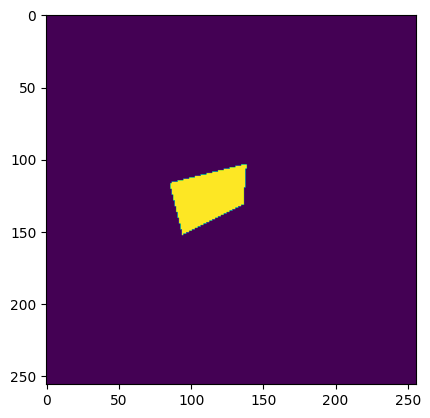

In [65]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import random
from tqdm.auto import tqdm
import cv2
import torch

dataset_path = Path('./datasets/')
coco_path = dataset_path / 'train2'

coco = COCO(coco_path / '_annotations.coco.json')

pytorch_path = Path('./Pytorch-UNet/data/')
img_path = pytorch_path / 'imgs'
mask_path = pytorch_path / 'masks'

# img_path.mkdir(parents=True, exist_ok=True)
# mask_path.mkdir(parents=True, exist_ok=True)
random.seed(42)

image_id = 0
img = coco.imgs[image_id]

print(img)

class_names = []

for key, value in coco.cats.items():
    class_names.append(value['name'])
print(coco.cats)
print(class_names)
cat_ids = coco.getCatIds()

anns_ids = coco.getAnnIds(imgIds=image_id, catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(anns_ids)

mask_tensor = torch.zeros(len(cat_ids), img['height'], img['width']).to(torch.int)

print(anns)
for ann in anns:
    mask = torch.from_numpy(coco.annToMask(ann)).to(torch.int)
    mask_tensor[ann['category_id']] = torch.bitwise_or(mask_tensor[ann['category_id']], mask)
    
mask_tensor_OHE = mask_tensor.permute(1, 2, 0)

original_img = cv2.imread(str(coco_path / img['file_name']))
    
# print(mask_tensor_OHE)
print(torch.unique(mask_tensor_OHE, dim=2))
    # cv2.imwrite(str(img_path / (rand_name + '.jpg')), new_img)
    
    # np.save(mask_path / rand_name, mask/255)
plt.imshow(original_img)
plt.imshow(mask)

mask_tensor != 0

In [63]:
# Tạo một tensor giả định cho mask
mask_data = torch.randint(0, 2, (1, 256, 256), dtype=torch.uint8)

# Tạo một đối tượng Mask từ tensor
mask = tv_tensors.Mask(mask_data)

print(mask_data)
print(mask)

tensor([[[1, 0, 1,  ..., 1, 0, 0],
         [1, 0, 0,  ..., 1, 0, 1],
         [1, 0, 0,  ..., 1, 0, 0],
         ...,
         [1, 0, 1,  ..., 0, 0, 1],
         [1, 0, 0,  ..., 0, 1, 0],
         [1, 1, 1,  ..., 0, 1, 1]]], dtype=torch.uint8)
Mask([[[1, 0, 1,  ..., 1, 0, 0],
       [1, 0, 0,  ..., 1, 0, 1],
       [1, 0, 0,  ..., 1, 0, 0],
       ...,
       [1, 0, 1,  ..., 0, 0, 1],
       [1, 0, 0,  ..., 0, 1, 0],
       [1, 1, 1,  ..., 0, 1, 1]]], dtype=torch.uint8)


In [72]:
from torchvision.transforms import ToTensor
from torchvision.datasets import CocoDetection
transform = ToTensor()

train_dataset = CocoDetection(root='./datasets/train2', annFile='./datasets/train2/_annotations.coco.json', transform=transform)

train_dataset[0]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


(tensor([[[0.4784, 0.3804, 0.3608,  ..., 0.5059, 0.4275, 0.4667],
          [0.4431, 0.4039, 0.4039,  ..., 0.3294, 0.4824, 0.2941],
          [0.4000, 0.4078, 0.4000,  ..., 0.4588, 0.5412, 0.3255],
          ...,
          [0.3961, 0.2667, 0.2392,  ..., 0.2980, 0.3333, 0.3725],
          [0.3373, 0.2157, 0.3529,  ..., 0.2941, 0.2706, 0.3373],
          [0.4039, 0.2941, 0.2745,  ..., 0.3333, 0.3137, 0.3451]],
 
         [[0.4745, 0.3765, 0.3569,  ..., 0.5059, 0.4275, 0.4667],
          [0.4392, 0.4000, 0.4000,  ..., 0.3294, 0.4824, 0.2941],
          [0.3961, 0.4039, 0.3961,  ..., 0.4588, 0.5412, 0.3255],
          ...,
          [0.4000, 0.2706, 0.2431,  ..., 0.3137, 0.3490, 0.3882],
          [0.3412, 0.2196, 0.3569,  ..., 0.3098, 0.2863, 0.3529],
          [0.4078, 0.2980, 0.2784,  ..., 0.3490, 0.3294, 0.3608]],
 
         [[0.4980, 0.4000, 0.3804,  ..., 0.5529, 0.4745, 0.5137],
          [0.4627, 0.4235, 0.4235,  ..., 0.3765, 0.5294, 0.3412],
          [0.4196, 0.4275, 0.4196,  ...,

In [108]:
# %%writefile model/disease_detection.py
import torch
from torchvision import transforms

import numpy as np
from PIL import Image
from pathlib import Path

from model.model_builder import resnet50_model

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import asyncio

class AI_model:
    def __init__(self, path_to_model: str):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self.model, info_data = resnet50_model(pretrain_model_path= path_to_model)
        self.class_names = info_data['class_names']

        self.img_transform = transforms.Compose([
            transforms.Resize(size= 224),
            transforms.ToTensor()
        ])

        target_layers = [self.model.layer4[-1]]
        # self.cam = GradCAM(model=self.model, target_layers=target_layers)
        # self.cam = ScoreCAM(model=self.model, target_layers=target_layers)
        # self.cam = HiResCAM(model=self.model, target_layers=target_layers)
        # self.cam = GradCAMPlusPlus(model=self.model, target_layers=target_layers)
        self.cam = AblationCAM(model=self.model, target_layers=target_layers)
        
    async def predict(self, img: Image):   
        img_tensor = self.img_transform(img)
        img_tensor_in_batch = img_tensor.unsqueeze(dim= 0)
        
        rgb_img = img_tensor.permute(1, 2, 0).numpy()
        
        
        
        self.model.eval()
        with torch.inference_mode():
            
            
            predict = self.model(img_tensor_in_batch)
            soft_max_persent = torch.softmax(predict, dim= 1)
            predicted_class = self.class_names[torch.argmax(predict, dim= 1)]

            
            
            probability = (soft_max_persent[0, torch.argmax(predict, dim= 1)].item())
            # print(predicted_class)
            
        targets = [ClassifierOutputTarget(torch.argmax(predict, dim= 1).item())]
        grayscale_cam = self.cam(input_tensor=img_tensor_in_batch, targets= targets)
        visualization = show_cam_on_image(rgb_img, grayscale_cam[0], use_rgb=True)

        results = {
            "image" : img,
            "predicted_image" : Image.fromarray(visualization),
            "class_name" : predicted_class,
            "class_prob" : probability
        }
        return results
        

In [109]:
from PIL import Image
from pathlib import Path
import random

# from model.disease_detection import AI_model

model = AI_model(path_to_model= './runs/classify/train1')

val_path = Path('./datasets/tomato/val')
imgs = list(val_path.glob(f'*/*.JPG'))

In [ ]:
import matplotlib.pyplot as plt

random_img = random.choice(imgs)
print(random_img)
img = Image.open(random_img)
results = await model.predict(img)

plt.figure(figsize=[7, 6])
plt.subplot(1, 2, 1)
plt.imshow(results['image'])
plt.title(results['class_name'])
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(results['predicted_image'])
plt.title(results['class_prob'])
plt.axis("off")

datasets\tomato\val\healthy\17010943329273842.JPG


 80%|██████████████████████████████████████████████████████████████████▏                | 51/64 [01:02<00:15,  1.23s/it]